# OpMode Emission Rate Assignment

---

In [1]:
import matplotlib.pyplot as plt

# font
plt.rcParams['font.sans-serif'] = ['Arial']
LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}    

# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

plt.rcParams['figure.dpi'] = 300

In [2]:
from analysis import Aggregator

# bins
agg = Aggregator()
SPEED_BIN = agg.SPEED_BIN
ACC_BIN = agg.ACC_BIN
DECEL_BIN = agg.BRAKE_DECEL_BIN
VSP_BIN = agg.VSP_BIN

## 1 Overall aggregation results

The overall aggregation results are provided in the `\data\agg_overall` directory.

In [3]:
import pickle
with open("./data/agg/agg_overall.pkl", 'rb') as f:
    agg_overall = pickle.load(f)
agg_overall['brakFrac'] = agg_overall['brakeCount'] / agg_overall['trajCount']
agg_overall

,vehNum,trajCount,matchedCount,brakeCount,brakeEventNum,mileage,speedBinCount,initSpeedBinCount,accBinCount,brakeDecelBinCount,brakeDecelBinMPHCount,VSPBinCount,OpModeCount,brakFrac
0,1175690,2963882212,2963882212,1022463199,259549307,17187642.0,"[983351886, 194969788, 198639783, 208770904, 2...","[40537812, 14559070, 15334545, 16778724, 18501...","[0, 2031919, 4959233, 11220684, 22936673, 4389...","[21309074, 127810233, 113708631, 95866677, 816...","[0, 0, 0, 0, 1889746, 4037548, 8540429, 164641...","[3278028, 3765854, 4355231, 5035235, 5826667, ...","[352692562, 798267033, 505956974, 440613599, 1...",0.344974


Basic information:
- trajectory count: `2,963,882,212`
- braking fraction: `34.5%`

In [4]:
agg_overall['brakeFreq'] = agg_overall['brakeEventNum'] / agg_overall['mileage']
agg_overall['brakeTimeMean'] = agg_overall['brakeCount'] / agg_overall['brakeEventNum']
agg_overall['brakeDecelMean'] = [sum(agg_overall['brakeDecelBinCount'].loc[0] / agg_overall['brakeCount'].loc[0] * DECEL_BIN[:-1])]
agg_overall['speedMean'] = [sum(agg_overall['speedBinCount'].loc[0] / agg_overall['trajCount'].loc[0] * SPEED_BIN[:-1])]
agg_overall['initSpeedMean'] = [sum(agg_overall['initSpeedBinCount'].loc[0] / agg_overall['brakeCount'].loc[0] * SPEED_BIN[:-1])]
print("braking frequency", agg_overall['brakeFreq'].loc[0])
print("average speed", agg_overall['speedMean'].loc[0])
print("average initial braking speed", agg_overall['initSpeedMean'].loc[0])
print("average braking duration", agg_overall['brakeTimeMean'].loc[0])
print("average braking decel", agg_overall['brakeDecelMean'].loc[0])

braking frequency 15.100925827987341
average speed 18.989343673013682
average initial braking speed 7.294916743502278
average braking duration 3.9393794220379097
average braking decel 0.885026242690227


In [5]:
frac = agg_overall['brakeDecelBinCount'].loc[0] / agg_overall['trajCount'].loc[0] * 100
frac[:15].sum()

28.960459816005667

28.96% of the braking occurs under deceleration lower than 1.5 m/s2

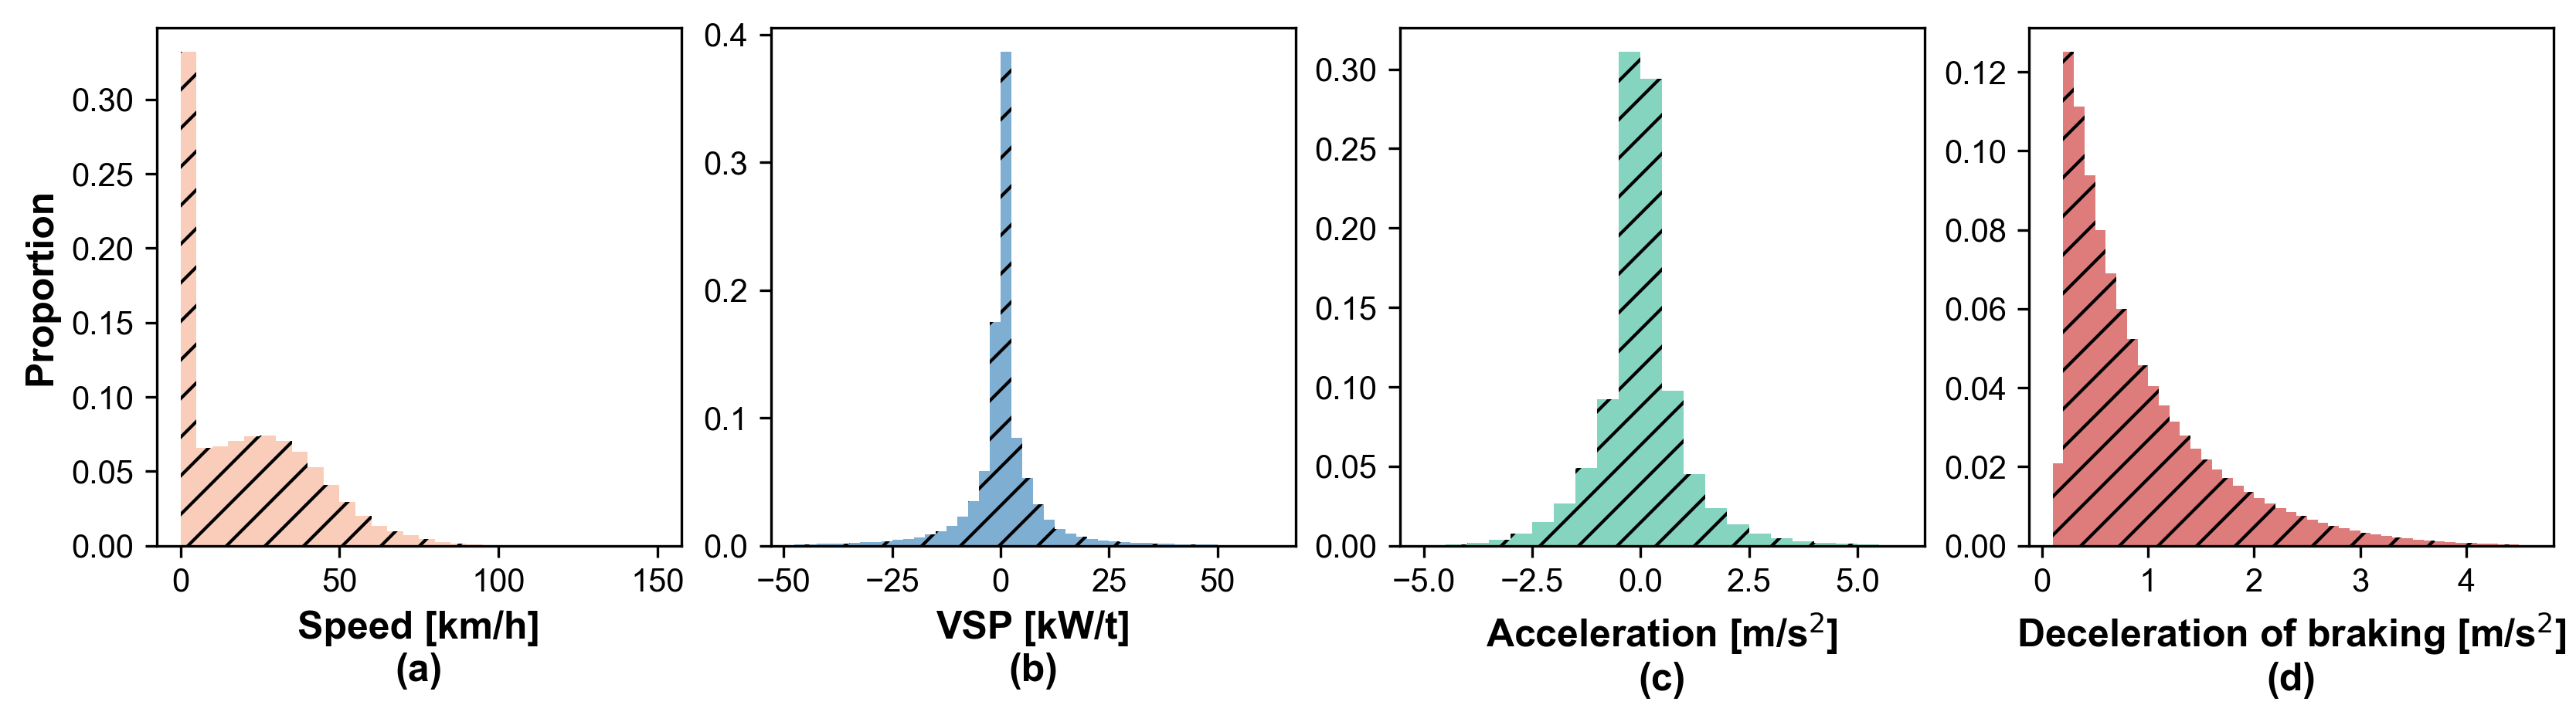

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(11,3), constrained_layout=True)

# speed
ax1.stairs(agg_overall['speedBinCount'].loc[0] / agg_overall['trajCount'].loc[0], SPEED_BIN, color=ORANGE, hatch='//', fill=True, alpha=0.6)
ax1.set_xlabel("Speed [km/h]\n(a)", fontdict=LABEL_FONT)
ax1.set_ylabel("Proportion", fontdict=LABEL_FONT)

# VSP
ax2.stairs(agg_overall['VSPBinCount'].loc[0] / agg_overall['trajCount'].loc[0], VSP_BIN, color=BLUE, hatch='//', fill=True, alpha=0.6)
ax2.set_xlabel("VSP [kW/t]\n(b)", fontdict=LABEL_FONT)

# acc
ax3.stairs(agg_overall['accBinCount'].loc[0] / agg_overall['trajCount'].loc[0], ACC_BIN, color=DEEPGREEN, hatch='//', fill=True, alpha=0.6)
ax3.set_xlabel("Acceleration [m/s$^2$]\n(c)", fontdict=LABEL_FONT)

# VSP
ax4.stairs(agg_overall['brakeDecelBinCount'].loc[0] / agg_overall['brakeCount'].loc[0], DECEL_BIN, color=RED, hatch='//', fill=True, alpha=0.6)
ax4.set_xlabel("Deceleration of braking [m/s$^2$]\n(d)", fontdict=LABEL_FONT)

plt.show()

The next step is to calculate the overall brake wear emission.

$$
ER_{avg} = \frac{1}{3}\times\sum_{m\in materials}\sum_{j\in bins} p(decel_j)\cdot ER^m(decel_j)
$$

In [7]:
# calculate the braking deceleration proportional distribution
agg_overall['brakeDecelBinFrac'] = agg_overall['brakeDecelBinCount'] / agg_overall['brakeCount']
brakeDecelBinFrac = agg_overall['brakeDecelBinCount'].iloc[0] / agg_overall['brakeCount'].iloc[0]

# ER calculator
from emission import BWETool
bwe = BWETool()
ER = bwe.ER

# calculate the average ER using the updated ER-decel curve and the MOVES curve
ER_avg = sum(ER.calER(DECEL_BIN[:-1], 'avg') * brakeDecelBinFrac)
ER_avg_MOVES = sum(ER.calER(DECEL_BIN[:-1], 'MOVES') * brakeDecelBinFrac)

ER_avg, ER_avg_MOVES

(2.2050418445692017, 4.767713733122556)

In [8]:
(ER_avg_MOVES - ER_avg) / ER_avg_MOVES

0.5375054023797196

The average ER is 2.205 g/hr/veh, 53.75% lower than 4.768 g/hr/veh calculated using MOVES' curve.

## 2 OpMode aggregation results

In [9]:
with open("./data/agg/agg_OpMode.pkl", 'rb') as f:
    agg_OpMode = pickle.load(f)
agg_OpMode.head()

,trajCount,matchedCount,brakeCount,brakeDecelBinCount
0,352692562,352692562,352692562,"[0, 0, 0, 0, 0, 0, 0, 0, 2641573, 41249051, 36..."
1,798267033,798267033,50873939,"[11961873, 32081550, 6682769, 144994, 2749, 0,..."
11,505956974,505956974,473621687,"[4630226, 70554463, 81996575, 73582303, 630184..."
12,440613599,440613599,15451670,"[4716975, 10734695, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
13,198804569,198804569,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 2.1 Braking profile

The key step to calculate brake wear emissions is to assign ERs to OpModes properly. Two key elements in each OpMode for this task are:  
- braking fraction [%], and
- braking deceleration distribution.

In [10]:
agg_OpMode['brakeFrac'] = agg_OpMode['brakeCount'] / agg_OpMode['trajCount']
agg_OpMode['brakeDecelBinFrac'] = agg_OpMode['brakeDecelBinCount'] / agg_OpMode['brakeCount']

In [11]:
agg_OpMode['brakeCount'] / agg_OpMode['brakeCount'].sum()

0     0.344944
1     0.049756
11    0.463216
12    0.015112
13         0.0
14         0.0
15         0.0
16         0.0
21    0.113643
22    0.010283
23         0.0
24         0.0
25         0.0
27         0.0
28         0.0
29         0.0
30         0.0
33    0.003045
35         0.0
37         0.0
38         0.0
39         0.0
40         0.0
Name: brakeCount, dtype: object

In [12]:
import numpy as np
decels = np.arange(0.1, 4.6, 0.1)
agg_OpMode['brakeDecelBinFrac'].apply(lambda x: sum(decels * x))

0     1.690422
1     0.190209
11    0.489207
12    0.169473
13         NaN
14         NaN
15         NaN
16         NaN
21    0.521305
22    0.219323
23         NaN
24         NaN
25         NaN
27         NaN
28         NaN
29         NaN
30         NaN
33    0.589040
35         NaN
37         NaN
38         NaN
39         NaN
40         NaN
Name: brakeDecelBinFrac, dtype: float64

The distribution of braking fraction is different from that in MOVES, especially in OpMode 21, 22, and 33.

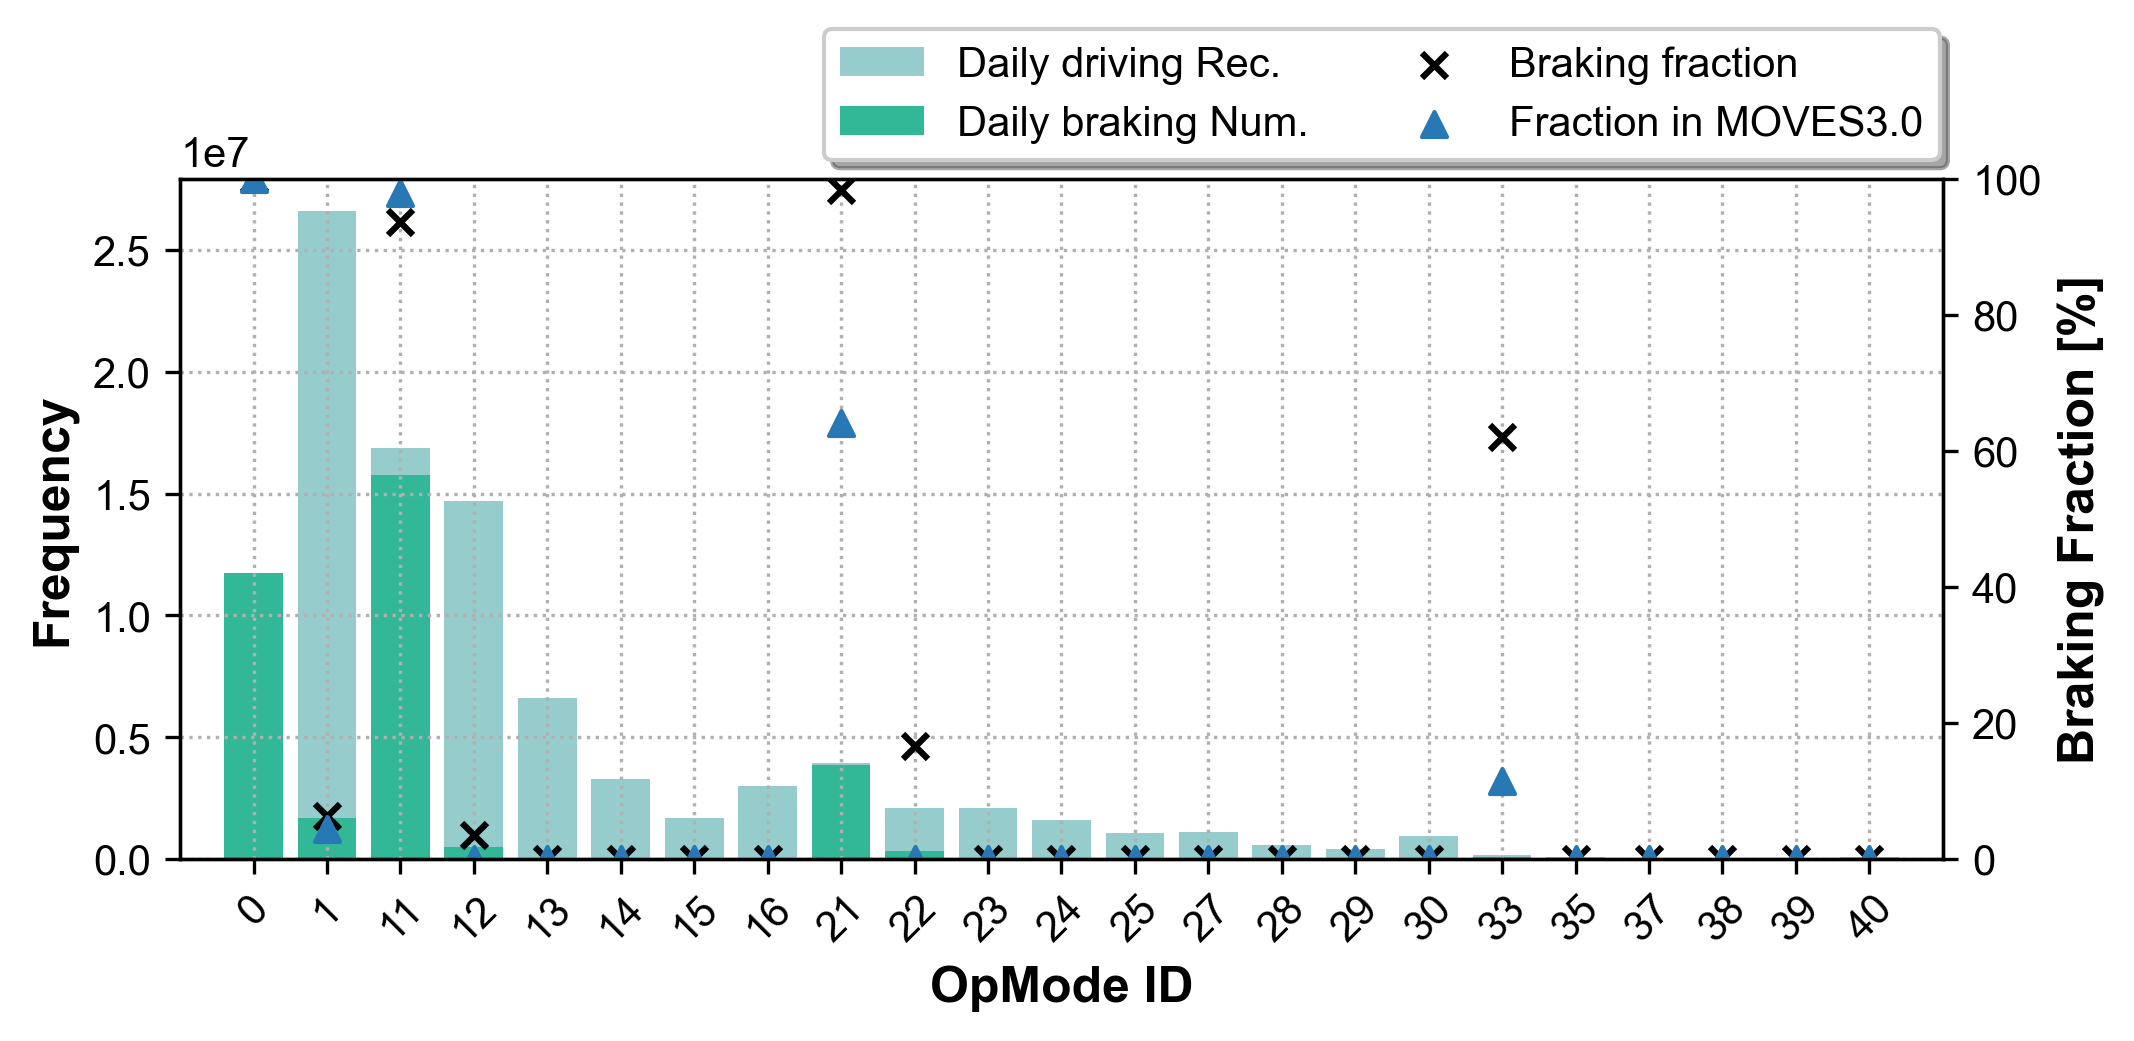

In [13]:
# plot OpMode info
fig, ax = plt.subplots(1,1, figsize=(7,3), constrained_layout=True)

# count-bar
modes = np.arange(0,agg_OpMode.shape[0])
ax.bar(modes, agg_OpMode['trajCount'] / 30, color=GREEN, label="Daily driving Rec.", zorder=1)
ax.bar(modes, agg_OpMode['brakeCount'] / 30, color=DEEPGREEN, label="Daily braking Num.", zorder=1)

ax.set_xlim(-1,agg_OpMode.shape[0])
ax.set_xticks(modes)
ax.set_xticklabels(agg_OpMode.index, rotation=45)

# frac-scatter
ax_ = ax.twinx()
ax_.scatter(modes, agg_OpMode['brakeFrac']*100, color="k", marker="x", label="Braking fraction", zorder=2)
ax_.set_ylim(0, 100)

# frac in MOVES-scatter
x_MOVES = modes
frac_MOVES = np.array((100, 4.37, 97.8, 0, 0, 0, 0, 0, 64.1, 0, 0, 0, 0, 0, 0, 0, 0, 11.5, 0, 0, 0, 0, 0))
ax_.scatter(x_MOVES, frac_MOVES, marker="^", color=BLUE, label="Fraction in MOVES3.0", zorder=2)

# labels
ax.set_xlabel("OpMode ID", fontdict=LABEL_FONT)
ax.set_ylabel("Frequency", fontdict=LABEL_FONT)
ax_.set_ylabel("Braking Fraction [%]", fontdict=LABEL_FONT)

ax.grid(axis="y", linestyle=":", zorder=0)
ax.grid(axis="x", linestyle=":", zorder=0)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.25), bbox_transform=ax.transAxes, ncol=2, shadow=True)
plt.show()

In [14]:
agg_OpMode.loc[[0,1,11,12,13,21]]['trajCount'].sum() / agg_OpMode['trajCount'].sum()

0.8146537808500468

The majority driving records are contributed by OpMode 0, 1, 11, 12, 13, and 21 with a proportion of 81.5%.

In [15]:
agg_OpMode.loc[[0,11,21]]['brakeCount'].sum() / agg_OpMode['brakeCount'].sum()

0.9218033450219072

And the majority of braking samples are generated in OpMode 0, 11, and 21 with a proportion of 92.2%.

### 2.2 Emission rate

#### *MOVES Method*

The OpMode emission rate calculation method in MOVES is shown below:
$$
ER^i = p^i(brak.) \times ER_{avg}\quad\forall i\in OpModes
$$
> - $p(brak.)_{i}$ is the braking fraction in each OpMode.  

In [16]:
agg_OpMode['PM10 ER MOVES'] = agg_OpMode['brakeFrac'] * ER_avg

In [17]:
OpModeERs_MOVES = agg_OpMode['PM10 ER MOVES'].to_numpy()
np.save("./data/agg/OpModeERs_MOVES.npy", OpModeERs_MOVES)

#### *Modified Method*

However, the braking deceleration in each OpMode is also worth consideration. Here we provide another calculation method considering decel distribution:
$$
ER^i = \frac{1}{3}\times p^i(brak.) \times \sum_{m\in materials}\sum_{j\in bins} p^i(decel_j) \times ER^m(decel_j)\quad\forall i\in OpModes
$$
> - $p^i(decel_j)$ is the proportion of each braking deceleration bin $j$ in OpMode $i$.
> - $ER^m(decel_j)$ is the corresponding emission rate of deceleration bin $i$ for material $m$ calculated from the ER-decel curve.

In [18]:
agg_OpMode['PM10 ER Avg'] = agg_OpMode.apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'avg') * x['brakeDecelBinFrac'] * x['brakeFrac']), axis=1)
agg_OpMode['PM10 ER LM'] = agg_OpMode.apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'LM') * x['brakeDecelBinFrac'] * x['brakeFrac']), axis=1)
agg_OpMode['PM10 ER SM'] = agg_OpMode.apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'SM') * x['brakeDecelBinFrac'] * x['brakeFrac']), axis=1)
agg_OpMode['PM10 ER NAO'] = agg_OpMode.apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'NAO') * x['brakeDecelBinFrac'] * x['brakeFrac']), axis=1)
agg_OpMode.fillna(0, inplace=True)

# generate the OpMode ERs
OpModeERs = agg_OpMode['PM10 ER Avg'].to_numpy()
# np.save("./data/agg/OpModeERs.npy", OpModeERs)

In [19]:
import numpy as np
import pandas as pd

OpModes = [0,1,11,12,13,14,15,16,21,22,23,24,25,27,28,29,30,33,35,37,38,39,40]
ERs = pd.DataFrame({'OpModeID':OpModes, 'ER':np.load("./data/agg/OpModeERs.npy")})
ERs

,OpModeID,ER
0,0,6.221761
1,1,0.000219
2,11,0.092932
3,12,0.000074
4,13,0.000000
5,14,0.000000
6,15,0.000000
7,16,0.000000
8,21,0.105777
9,22,0.000745


Using these two methods, we obtain the ER for each OpMode. It's obvious that OpMode 0 has the highest Avg.ER using both methods. But the ERs of OpMode 11, 21, 22 and 33 calculated by method A are higher than that of method B. This difference comes from the differential consideration of two methods.

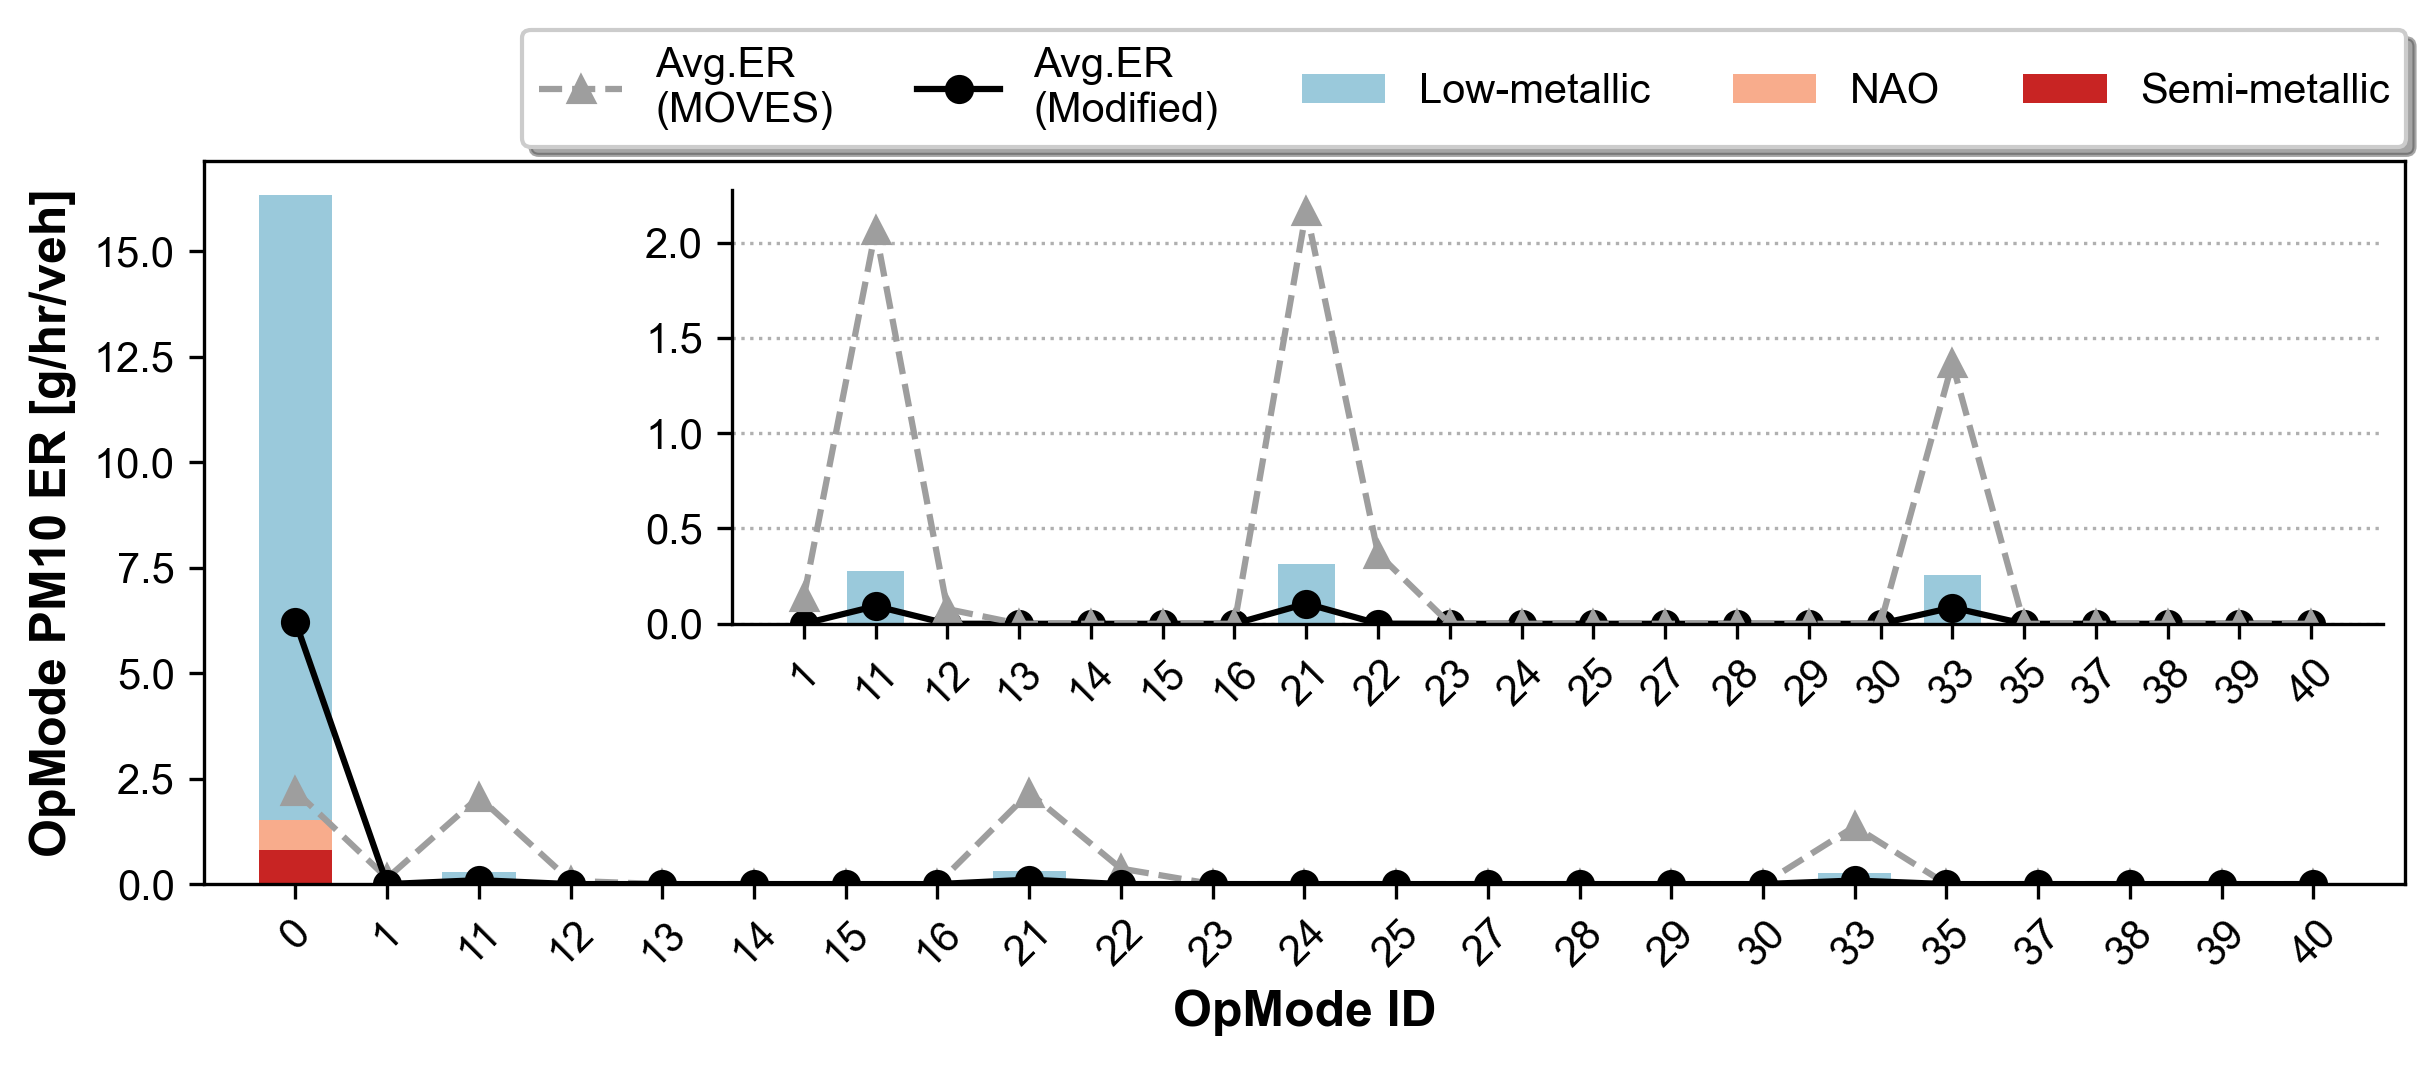

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# ER bar
modes = np.arange(0,agg_OpMode.shape[0])
ax.bar(modes, agg_OpMode['PM10 ER LM'], color=LIGHTBLUE, label="Low-metallic", zorder=1)
ax.bar(modes, agg_OpMode['PM10 ER NAO'], color=ORANGE, label="NAO", zorder=1)
ax.bar(modes, agg_OpMode['PM10 ER SM'], color=RED, label="Semi-metallic", zorder=1)

ax.set_xlim(-1,agg_OpMode.shape[0])
ax.set_xticks(modes)
ax.set_xticklabels(agg_OpMode.index, rotation=45)

# plot
ax.plot(modes, agg_OpMode['PM10 ER MOVES'], color=GREY, marker="^", linestyle="--", label="Avg.ER\n(MOVES)", zorder=2)
ax.plot(modes, agg_OpMode['PM10 ER Avg'], color="k", marker="o", label="Avg.ER\n(Modified)", zorder=2)

# labels
ax.set_xlabel("OpMode ID", fontdict=LABEL_FONT)
ax.set_ylabel("OpMode PM10 ER [g/hr/veh]", fontdict=LABEL_FONT)

# child axes
w, h = 0.75, 0.6
ax_ = ax.inset_axes([1-w-0.01, 1-h-0.04, w, h])
modes_ = np.arange(1,agg_OpMode.shape[0])
ax_.bar(modes_, agg_OpMode['PM10 ER LM'][1:], color=LIGHTBLUE, label="Low-metallic", zorder=2)
ax_.bar(modes_, agg_OpMode['PM10 ER NAO'][1:], color=ORANGE, label="NAO", zorder=2)
ax_.bar(modes_, agg_OpMode['PM10 ER SM'][1:], color=RED, label="Semi-metallic", zorder=2)
ax_.set_xlim(0,agg_OpMode.shape[0])
ax_.set_xticks(modes_)
ax_.set_xticklabels(agg_OpMode.index[1:], rotation=45)
ax_.plot(modes_, agg_OpMode['PM10 ER Avg'][1:], color="k", marker="o", label="Average", zorder=2)
ax_.plot(modes_, agg_OpMode['PM10 ER MOVES'][1:], color=GREY, marker="^", linestyle="--", label="Avg.ER*Brk.Frac.\n(used in MOVES)", zorder=2)
ax_.grid(axis="y", linestyle=":", zorder=0)
ax_.spines['top'].set_visible(False)
ax_.spines['right'].set_visible(False)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.21), bbox_transform=ax.transAxes, ncol=5, shadow=True)
plt.show()

The result shows that method A would underestimate the ER of OpMode with high deceleration of braking, such as OpMode 11, 21, and 33. In contrast, the ER of OpMode 0 is overestimated by method A.

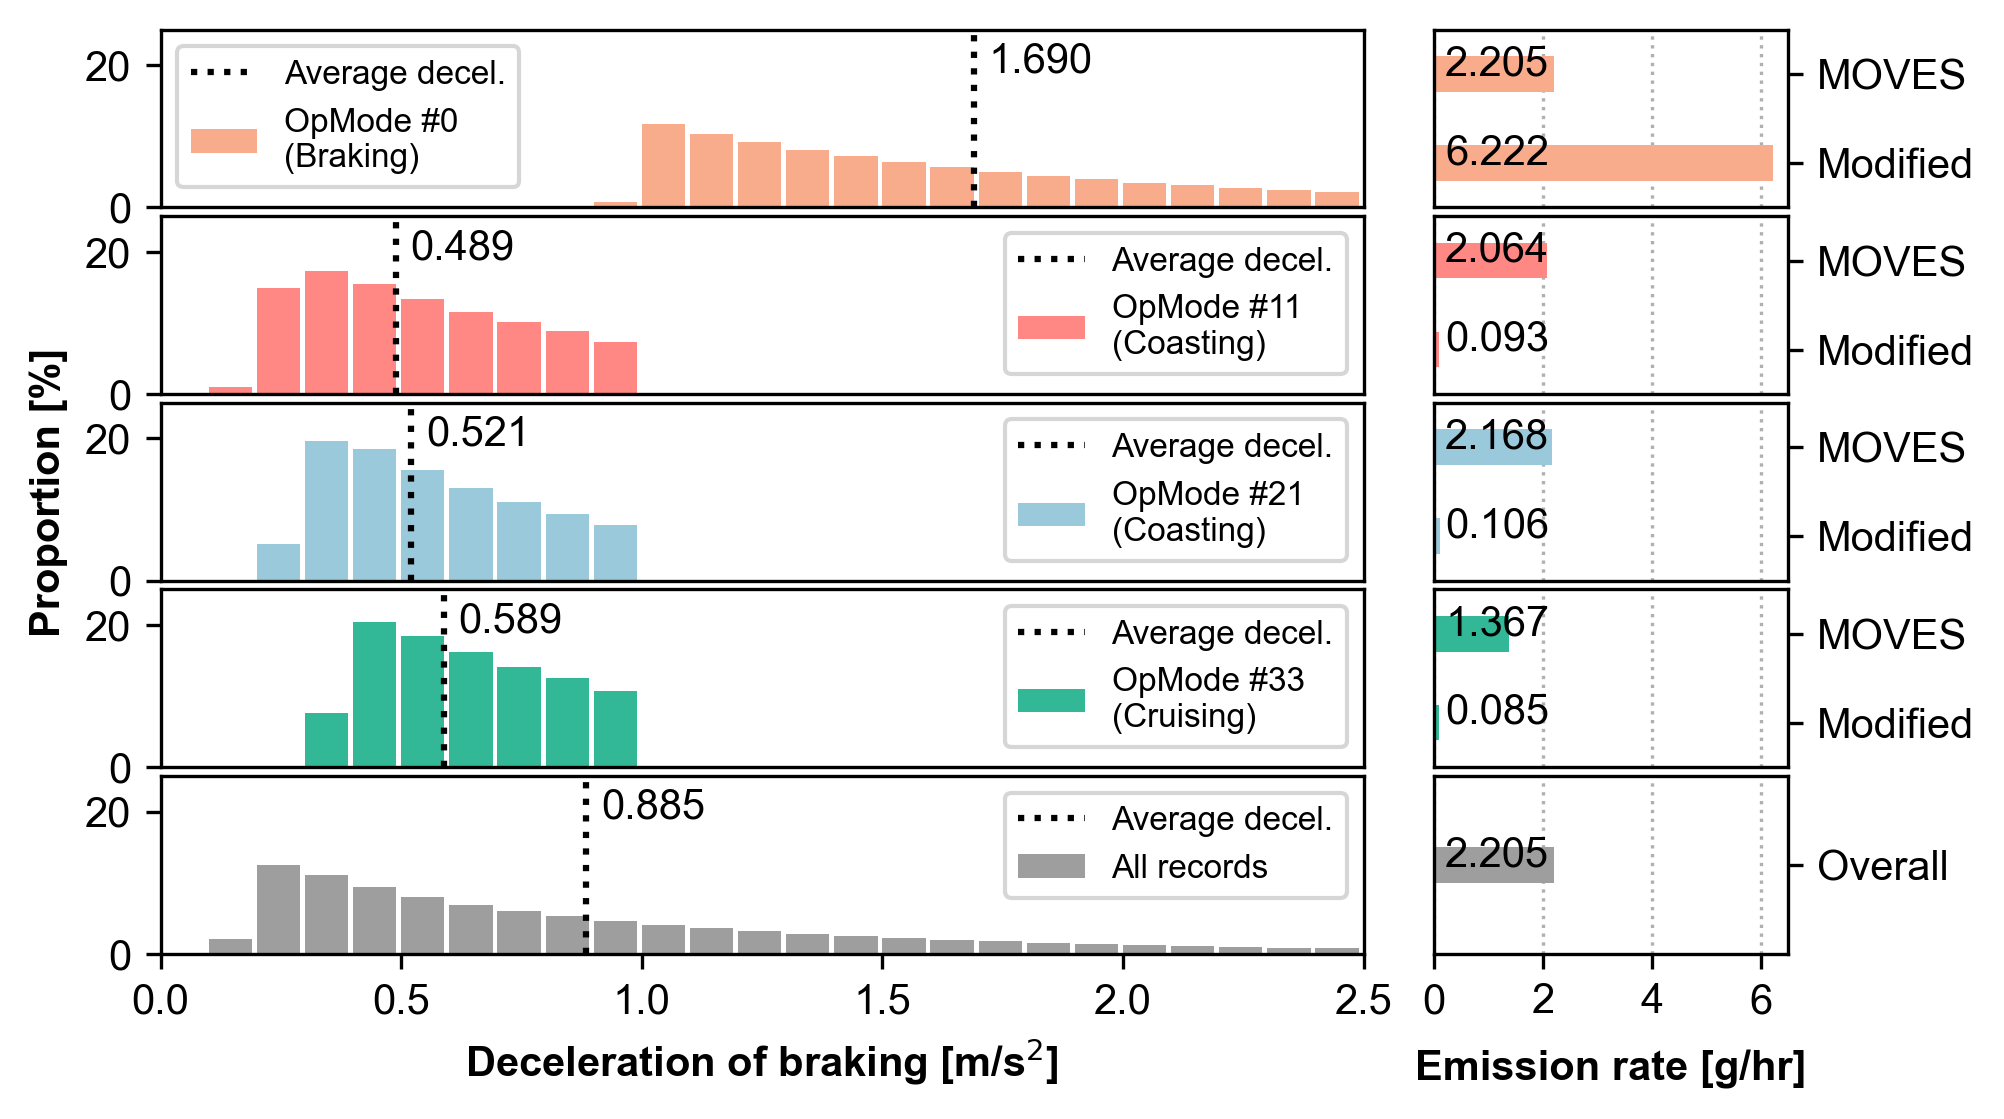

In [22]:
fig = plt.figure(figsize=(7,4))

ax1 = plt.subplot2grid((5,4), (0,0), colspan=3)  # 0-hist
ax2 = plt.subplot2grid((5,4), (1,0), colspan=3)  # 11-hist
ax3 = plt.subplot2grid((5,4), (2,0), colspan=3)  # 21-hist
ax4 = plt.subplot2grid((5,4), (3,0), colspan=3)  # 33-hist
ax5 = plt.subplot2grid((5,4), (4,0), colspan=3)  # all-hist

ax6 = plt.subplot2grid((5,4), (0,3))  # 0-bar
ax7 = plt.subplot2grid((5,4), (1,3))  # 11-bar
ax8 = plt.subplot2grid((5,4), (2,3))  # 21-bar
ax9 = plt.subplot2grid((5,4), (3,3))  # 33-bar
ax10 = plt.subplot2grid((5,4), (4,3))  # all-bar

# hist
decels = np.arange(0.1, 4.6, 0.1)

ax1.bar(decels, agg_OpMode.loc[0]['brakeDecelBinFrac']*100, width=0.09, zorder=2, align='edge', color=ORANGE, label="OpMode #0\n(Braking)")
avg_decel = sum(decels * agg_OpMode.loc[0]['brakeDecelBinFrac'])
ax1.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel.")
ax1.text(avg_decel+0.03, 19, "%.3f" % avg_decel, zorder=2, color='k')

ax2.bar(decels, agg_OpMode.loc[11]['brakeDecelBinFrac']*100, width=0.09, zorder=2, align='edge', color=PINK, label="OpMode #11\n(Coasting)")
avg_decel = sum(decels * agg_OpMode.loc[11]['brakeDecelBinFrac'])
ax2.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel.")
ax2.text(avg_decel+0.03, 19, "%.3f" % avg_decel, zorder=2, color='k')

ax3.bar(decels, agg_OpMode.loc[21]['brakeDecelBinFrac']*100, width=0.09, zorder=2, align='edge', color=LIGHTBLUE, label="OpMode #21\n(Coasting)")
avg_decel = sum(decels * agg_OpMode.loc[21]['brakeDecelBinFrac'])
ax3.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel.")
ax3.text(avg_decel+0.03, 19, "%.3f" % avg_decel, zorder=2, color='k')

ax4.bar(decels, agg_OpMode.loc[33]['brakeDecelBinFrac']*100, width=0.09, zorder=2, align='edge', color=DEEPGREEN, label="OpMode #33\n(Cruising)")
avg_decel = sum(decels * agg_OpMode.loc[33]['brakeDecelBinFrac'])
ax4.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel.")
ax4.text(avg_decel+0.03, 19, "%.3f" % avg_decel, zorder=2, color='k')

ax5.bar(decels, agg_overall['brakeDecelBinFrac'].iloc[0]*100, width=0.09, zorder=2, align='edge', color=GREY, label="All records")
avg_decel = sum(decels * agg_overall['brakeDecelBinFrac'].iloc[0])
ax5.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel.")
ax5.text(avg_decel+0.03, 19, "%.3f" % avg_decel, zorder=2, color='k')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 2.5)
    ax.set_ylim(0, 25)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', colors='none')
    ax.legend(fontsize=8)
ax1.legend(fontsize=8, loc=2)
ax5.set_xlim(0, 2.5)
ax5.set_ylim(0, 25)
ax5.legend(fontsize=8)
# labels
ax3.set_ylabel("Proportion [%]", fontdict=LABEL_FONT, fontsize=10)
ax5.set_xlabel("Deceleration of braking [m/s$^2$]", fontdict=LABEL_FONT, fontsize=10)


# ER comparison
ax6.barh(np.arange(0,2), agg_OpMode.loc[0][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=ORANGE)
ax6.text(0.2, 0.9, "%.3f"%agg_OpMode.loc[0]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax6.text(0.2, -0.1, "%.3f"%agg_OpMode.loc[0]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax7.barh(np.arange(0,2), agg_OpMode.loc[11][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=PINK)
ax7.text(0.2, 0.9, "%.3f"%agg_OpMode.loc[11]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax7.text(0.2, -0.1, "%.3f"%agg_OpMode.loc[11]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax8.barh(np.arange(0,2), agg_OpMode.loc[21][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=LIGHTBLUE)
ax8.text(0.2, 0.9, "%.3f"%agg_OpMode.loc[21]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax8.text(0.2, -0.1, "%.3f"%agg_OpMode.loc[21]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax9.barh(np.arange(0,2), agg_OpMode.loc[33][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=DEEPGREEN)
ax9.text(0.2, 0.9, "%.3f"%agg_OpMode.loc[33]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax9.text(0.2, -0.1, "%.3f"%agg_OpMode.loc[33]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax10.barh(np.arange(0,1), ER_avg, height=0.2, zorder=2, color=GREY)
ax10.text(0.2, -0.05, "%.3f"%ER_avg, zorder=2, color='k', ha='left', va='bottom')

# set format
for ax in [ax6, ax7, ax8, ax9]:
    ax.set_xticks([0,2,4,6])
    ax.set_xticklabels([])
    ax.set_yticks([0,1])
    ax.set_yticklabels(['Modified', 'MOVES'])
    ax.set_ylim(-0.5,1.5)
    ax.grid(axis="x", linestyle=":", zorder=0)
    ax.yaxis.tick_right()
    # ax.spines['bottom'].set_color('none')
    ax.tick_params(axis='x', colors='none')
ax10.set_xticks([0,2,4,6])
ax10.set_yticks([0])
ax10.set_yticklabels(['Overall'])
ax10.set_ylim(-0.5,0.5)
ax10.grid(axis="x", linestyle=":", zorder=0)
ax10.yaxis.tick_right()
ax10.set_xlabel("Emission rate [g/hr]", fontdict=LABEL_FONT, fontsize=10, labelpad=7)

for ax in [ax6, ax7, ax8, ax9, ax10]:
    ax.set_xlim(0, 6.5)
plt.subplots_adjust(hspace=0.05)
plt.show()


In [ ]:
ER_avg = sum(agg_overall['OpModeCount'].loc[0] / agg_overall['trajCount'].loc[0] * OpModeERs)
BWE = ER_avg * agg_overall['trajCount'].loc[0] / 3600
EF = BWE / agg_overall['mileage'].loc[0] * 1000
EF

36.43726079352516

In [ ]:
BWE / agg_overall['brakeEventNum']  # g

0    0.002413
Name: brakeEventNum, dtype: float64

The average EF in the study area is 36.44 mg/km/veh, generated from each braking with an average emission of 2.4 mg.